<a href="https://colab.research.google.com/github/AishaLichtner/projects-2019/blob/master/Blocktimes_on_all_flights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow.compat.v1 as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,Conv1D,Conv3D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge



from tensorflow.keras import optimizers as opt
import tensorflow.keras.backend as K
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import datetime
import statistics


#get last sunday of the month
import sys
import calendar

from tensorflow.keras import layers

print(tf.__version__)

import numpy as np     # matrix structures, linear algebra functions etc
from sklearn.linear_model import LinearRegression   # linear regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error   # accuracy metrics

import io


1.15.0


#Read  data from csv file


In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/data/blocks.csv"
#data = pd.read_csv(io.StringIO(uploaded["blocks.csv"].decode('utf-8')))
data= pd.read_csv(path, sep = ';', encoding="utf-8-sig")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data.head()

,Acreg,Version,Std UTC,Flightcode,AOC,DP Iatacode,AR Iatacode,Sta Utc,Rm Off Block Utc,Rm On Block Utc,Rm Takeoff Utc,Rm Touchdown Utc,TaxiOut,TaxiIn,BlkSched,ActualBlock,Weekday
0,9HAGU,A333,30.09.2018 15:45,DY7011,WET,CPH,JFK,01.10.2018 00:05,30.09.2018 18:31,01.10.2018 04:28,30.09.2018 19:07,01.10.2018 04:20,36,8.0,500.0,597.0,DOM
1,9HAGU,A333,02.10.2018 02:30,DY7812,WET,JFK,CPH,02.10.2018 09:45,02.10.2018 09:00,02.10.2018 16:45,02.10.2018 09:25,02.10.2018 16:40,25,5.0,435.0,465.0,MAR
2,9HAGU,A333,04.05.2019 10:35,D85551,WET,ARN,BCN,04.05.2019 14:00,04.05.2019 10:39,04.05.2019 13:56,04.05.2019 10:53,04.05.2019 13:50,14,6.0,205.0,197.0,SÁB
3,9HAGU,A333,04.05.2019 15:30,D85552,WET,BCN,ARN,04.05.2019 19:05,04.05.2019 15:30,04.05.2019 19:18,04.05.2019 15:58,04.05.2019 19:13,28,5.0,215.0,228.0,SÁB
4,9HAGU,A333,05.05.2019 10:35,D85551,WET,ARN,BCN,05.05.2019 14:00,05.05.2019 10:40,05.05.2019 13:54,05.05.2019 10:53,05.05.2019 13:46,13,8.0,205.0,194.0,DOM


In [0]:
#exclude flights that are done with other planes
data= data.loc[data['AOC'] != "WET"]
data.dropna()
data.shape


(664059, 17)

In [0]:
data.loc[data["Acreg"] ==


,Acreg,Version,Std UTC,Flightcode,AOC,DP Iatacode,AR Iatacode,Sta Utc,Rm Off Block Utc,Rm On Block Utc,Rm Takeoff Utc,Rm Touchdown Utc,TaxiOut,TaxiIn,BlkSched,ActualBlock,Weekday
3262,DI789,NaN,06.05.2018 01:20,DI7148,NaN,BOS,LGW,06.05.2018 07:40,06.05.2018 01:09,06.05.2018 07:55,06.05.2018 01:22,06.05.2018 07:50,13,5.0,380.0,406.0,DOM
6085,EIFHA,737-800,01.01.2017 06:55,D8120,NAI,HEL,RVN,01.01.2017 08:15,01.01.2017 06:56,01.01.2017 08:25,01.01.2017 07:14,01.01.2017 08:21,18,4.0,80.0,89.0,DOM
6086,EIFHA,737-800,01.01.2017 08:45,D8121,NAI,RVN,HEL,01.01.2017 10:05,01.01.2017 08:55,01.01.2017 10:14,01.01.2017 09:07,01.01.2017 10:10,12,4.0,80.0,79.0,DOM
6087,EIFHA,737-800,01.01.2017 10:35,D8152,NAI,HEL,IVL,01.01.2017 12:15,01.01.2017 10:56,01.01.2017 12:33,01.01.2017 11:06,01.01.2017 12:28,10,5.0,100.0,97.0,DOM
6088,EIFHA,737-800,01.01.2017 12:45,D8153,NAI,IVL,HEL,01.01.2017 14:20,01.01.2017 13:20,01.01.2017 14:45,01.01.2017 13:24,01.01.2017 14:42,4,3.0,95.0,85.0,DOM


In [0]:
#just take relevant data in account and save a copy for later
data_kopiert= data.copy()

data=data[['ActualBlock', 'Std UTC', "DP Iatacode", "AR Iatacode", "BlkSched"]]
data["DiffBlock"] = abs(data["ActualBlock"]- data["BlkSched"])
data_kopiert["DiffBlock"] = abs(data["ActualBlock"]- data["BlkSched"])
data

,ActualBlock,Std UTC,DP Iatacode,AR Iatacode,BlkSched,DiffBlock
3211,406,06.05.2018 01:20,BOS,LGW,380,26
5924,168,01.06.2017 05:20,MAD,TFN,175,7
5925,173,01.06.2017 08:55,TFN,MAD,165,8
5926,250,02.06.2017 06:00,MAD,HEL,250,0
5927,289,02.06.2017 10:55,HEL,MAD,265,24
...,...,...,...,...,...,...
559169,742,25.10.2019 12:50,BCN,LAX,730,12
559170,659,26.10.2019 03:00,LAX,BCN,655,4
559171,524,26.10.2019 17:25,BCN,EWR,515,9
559172,436,27.10.2019 03:59,EWR,BCN,436,0


#Use one Hot Encoding for airport combinations


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [0]:
toEncode =data[['DP Iatacode','AR Iatacode']]

In [0]:
toEncode.tail()

,DP Iatacode,AR Iatacode
559169,BCN,LAX
559170,LAX,BCN
559171,BCN,EWR
559172,EWR,BCN
559173,BCN,JFK


In [0]:
toEncode.shape

(546863, 2)

With one Hot encoding we higher the dimnsion of the (546863, 2)- matrix, so we have more information, that the network can use.

In [0]:
# prepare input data
def prepare_inputsOH(X):
	ohe = OneHotEncoder(sparse=False)
	X_train_enc = ohe.fit_transform(X)
	return X_train_enc

In [0]:
print(prepare_inputsOH(toEncode))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
encodedOH = prepare_inputsOH(toEncode) #returns a
encodedOH = pd.DataFrame(encodedOH)
sum(encodedOH == 1) #double check, that this did not produce a matrix full of zeros

83028

In [0]:
print(encodedOH.isna())
print(encodedOH.shape)
print(data.shape)

          0      1      2      3      4    ...    403    404    405    406    407
0       False  False  False  False  False  ...  False  False  False  False  False
1       False  False  False  False  False  ...  False  False  False  False  False
2       False  False  False  False  False  ...  False  False  False  False  False
3       False  False  False  False  False  ...  False  False  False  False  False
4       False  False  False  False  False  ...  False  False  False  False  False
...       ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
546858  False  False  False  False  False  ...  False  False  False  False  False
546859  False  False  False  False  False  ...  False  False  False  False  False
546860  False  False  False  False  False  ...  False  False  False  False  False
546861  False  False  False  False  False  ...  False  False  False  False  False
546862  False  False  False  False  False  ...  False  False  False  False  False

[546863 rows x 

In [0]:
#fix some dimension problems
data.reset_index(drop=True, inplace=True)
encodedOH.reset_index(drop=True, inplace=True)
data.head()

,ActualBlock,Std UTC,DP Iatacode,AR Iatacode,BlkSched,DiffBlock
0,406,06.05.2018 01:20,BOS,LGW,380,26
1,168,01.06.2017 05:20,MAD,TFN,175,7
2,173,01.06.2017 08:55,TFN,MAD,165,8
3,250,02.06.2017 06:00,MAD,HEL,250,0
4,289,02.06.2017 10:55,HEL,MAD,265,24


In [0]:
#delete encoded information
data.pop("DP Iatacode") 
data.pop("AR Iatacode")

0         LGW
1         TFN
2         MAD
3         HEL
4         MAD
         ... 
546858    LAX
546859    BCN
546860    EWR
546861    BCN
546862    JFK
Name: AR Iatacode, Length: 546863, dtype: object

In [0]:
#concat original data with one hot encoding matrix
data=pd.concat([data,encodedOH ],axis = 1)
print(data)

        ActualBlock           Std UTC  BlkSched  DiffBlock  ...  404  405  406  407
0               406  06.05.2018 01:20       380         26  ...  0.0  0.0  0.0  0.0
1               168  01.06.2017 05:20       175          7  ...  0.0  0.0  0.0  0.0
2               173  01.06.2017 08:55       165          8  ...  0.0  0.0  0.0  0.0
3               250  02.06.2017 06:00       250          0  ...  0.0  0.0  0.0  0.0
4               289  02.06.2017 10:55       265         24  ...  0.0  0.0  0.0  0.0
...             ...               ...       ...        ...  ...  ...  ...  ...  ...
546858          742  25.10.2019 12:50       730         12  ...  0.0  0.0  0.0  0.0
546859          659  26.10.2019 03:00       655          4  ...  0.0  0.0  0.0  0.0
546860          524  26.10.2019 17:25       515          9  ...  0.0  0.0  0.0  0.0
546861          436  27.10.2019 03:59       436          0  ...  0.0  0.0  0.0  0.0
546862          504  27.10.2019 17:05       535         31  ...  0.0  0.0  0

#Split date into day hour and weekday and season

In [0]:
#exclude date colum of flightBlock so we can split it in more information
date = data.pop("Std UTC")
date.tail()

546858    25.10.2019 12:50
546859    26.10.2019 03:00
546860    26.10.2019 17:25
546861    27.10.2019 03:59
546862    27.10.2019 17:05
Name: Std UTC, dtype: object

In [0]:
#calculate the last sunday for a given month in given year
def lastSunday(year,month):
    if len(sys.argv) > 1:
        try:
            year = int(sys.argv[-1])
        except ValueError:
            pass
 
   
    last_sunday = max(week[-1] for week in calendar.monthcalendar(year, month))
    return last_sunday

In [0]:
#gives inforamtion if a date is in summer or winter season
#returns 1 for winterseason and 0 for summer season
def getSeason(d):

    if (d.month<3 or d.month > 10):
        return 1;
    elif (d.month == 3 and d.day < lastSunday(d.year, d.month)):
        return 1;
    elif (d.month == 10 and d.day >= lastSunday(d.year, d.month)):
        return 1;
    else:
        return 0;
    

In [0]:
#create some more categories like time of the day, weekday and season
dateForm=[datetime.datetime.strptime(s,'%d.%m.%Y %H:%M') for s in date]

times= [x.hour for x in dateForm]
weekdays =[x.weekday()+1 for x in dateForm]
summer=[(getSeason(x)==0)*1 for x in dateForm]


In [0]:
data['Time'] = times
data["Weekday"] = weekdays
data["Summer"] = summer
data.tail()

,ActualBlock,BlkSched,DiffBlock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,Time,Weekday,Summer
546858,742,730,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5,1
546859,659,655,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,6,1
546860,524,515,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,1
546861,436,436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7,0
546862,504,535,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,7,0


#Remove the outliers

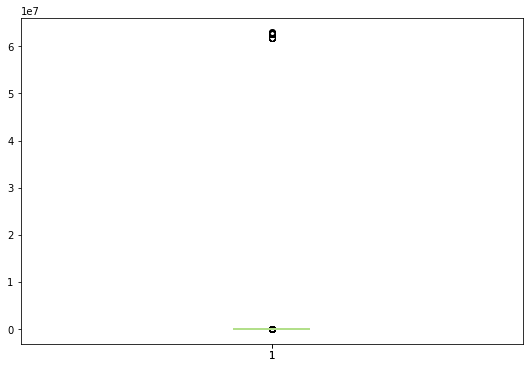

In [0]:
#Create boxplot of "ActualBlock" to see if there are outliers
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data["DiffBlock"])

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

## add patch_artist=True option to ax.boxplot() 
## to get fill color


bp = ax.boxplot(data["DiffBlock"], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

In [0]:
data.tail()

,ActualBlock,BlkSched,DiffBlock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,Time,Weekday,Summer
546858,742,730,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5,1
546859,659,655,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,6,1
546860,524,515,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,1
546861,436,436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7,0
546862,504,535,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,7,0


In [0]:
#find the outliers
oldSize=data.shape[0]
Q1 = data["DiffBlock"].quantile(0.25)
Q3 = data["DiffBlock"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(Q3)
print(Q1)

#outliars beeing filtered
data = data[~((data["DiffBlock"] < (Q1 - 1.5 * IQR)) |(data["DiffBlock"] > (Q3 + 1.5 * IQR)))]
data_kopiert = data_kopiert[~((data_kopiert["DiffBlock"] < (Q1 - 1.5 * IQR)) |(data_kopiert["DiffBlock"] > (Q3 + 1.5 * IQR)))]
print("percentage of non-outlier flights:")
print(data.shape[0]/oldSize )
print(data.shape)
print(data_kopiert.shape)

8.0
11.0
3.0
percentage of non-outlier flights:
0.9437738519519514
(516115, 414)
(516115, 17)


#Save copy for predictions later

In [0]:
#keep copy of all to predict later allData dimension 516115
allData= data.copy()
allData_labels=pd.DataFrame(allData["ActualBlock"])
allData.pop("ActualBlock")

1         168
2         173
3         250
5         132
6         269
         ... 
546857    659
546858    742
546859    659
546860    524
546861    436
Name: ActualBlock, Length: 516115, dtype: int64

In [0]:
data_kopiert.reset_index(drop=True, inplace=True)
actual= pd.DataFrame(data_kopiert["ActualBlock"])
allData_labels.equals(actual)

False

In [0]:

print(pd.concat([actual,allData_labels]).drop_duplicates(keep=False))
print(actual.head())
print(allData_labels.head())

Empty DataFrame
Columns: [ActualBlock]
Index: []
   ActualBlock
0          168
1          173
2          250
3          132
4          269
   ActualBlock
1          168
2          173
3          250
5          132
6          269


# Build some models

In [0]:
def build_model_simple():
    model = Sequential()
    model.add(Dense(12, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_deeper():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(12, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(5, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_wider():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(65, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

# Build costum loss function and build models with it

In [0]:
def custom_zwei():
     # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
            d= y_true -y_pred
            late = K.cast( K.greater(d,10),"float") *K.cast(K.square(d-10),"float32")
            early =  K.cast( K.less(d,-10),"float") *K.cast((K.square(d+10)),"float32")
            onTime= K.cast(0,"float32")
            return late+early+onTime
    return loss


In [0]:
def build_model_simple_loss():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(15, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss=custom_zwei(),
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_deeper_loss():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(12, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(5, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss=custom_zwei(),
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_wider_loss():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(65, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss=custom_zwei(),
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

# Build some machine learning models 

In [0]:
#linear Regression
modelRE = LinearRegression()



In [0]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)



# Build an evaluation function that tests on time predictions

In [0]:

def testModel( predict, label,mod):
   # print("This is evaluation of model on NOT clean test data for model " + stringArq)
    
    showScatter(predict,label)
    showPredictions(predict, label)
    showError(predict, label)
    onTime(predict,label)
    notLate(predict,label)
    #testSameFlight(specificFlight,mod)
   # showResults(predict,label)

In [0]:
#taking one specific flight to see if model gives same times
def testSameFlight(specFlight,model):
    a = specFlight.loc[specFlight["Time"] ==17 ]
    a= a.loc[a["Weekday"]==1]
    a= a.loc[a["Summer"]==0]
    print(a) 
    a.pop("ActualBlock")
    a=norm(a).values
    print("these are results for the same flight")
    print(model.predict(a).flatten())
 

In [0]:
def showScatter(predict, label):
    plt.scatter(label, predict)
    plt.xlabel('True Values [ActualBlock]')
    plt.ylabel('Predictions [ActualBlock]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-300, 300], [-300, 300])
    plt.show()

In [0]:
def showError(predict, label):
    error =  label-predict
    plt.hist(error, bins = 25)

    plt.xlabel("Prediction Error [ActualBlock]")
    _ = plt.ylabel("Count")

    plt.xlim([-100,100])
    plt.axvline(x=-10, color="red")
    plt.axvline(x=10, color = "red")
    plt.ylim([0,plt.ylim()[1]])
    plt.show()

    print("this is the median of error, negative indicates too early arrival, positive late arrival")
    print(statistics.median(error))
    print("this is the average error, negative indicates too early arrival, positive late arrival")
    print(abs(error).sum()/len(error))


In [0]:
def showPredictions(predict,label):
    tabel =pd.DataFrame()
    tabel["Test Predictions"] =predict
    tabel["Test ActualBlock"] =label
    print("These are the actual block times and their predictions")
    tabel.tail()

In [0]:
#check how many of the flights are NOT on time (+- 10 minutes)

def onTime(predict, label):
    delay = (abs(label-predict) > 10)*1
    print("this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:")
    print(sum(delay) / len(delay))


In [0]:
#check how many of the flights are more than 10 minutes late

def notLate(predict, label):
    delay = ((label-predict) > 10)*1
    print("this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:")
    print(sum(delay) / len(delay))


In [0]:
#show actual function and approximated function
def showResults(predict, l):
    plt.figure()
    plt.xlabel('Samples')
    plt.ylabel('Blocktimes')
    plt.plot(predict,
           label='Prediction')
    plt.plot(l,
           label = 'Real Values')
    plt.ylim([100,200])
    plt.legend()

# training phase

Splitting the data 

In [0]:
#splitting data into trianing and test set still including the labels!

train_X = data.sample(frac=0.8,random_state=0)
test_X = data.drop(train_X.index)
train_labels = train_X.pop("ActualBlock")
test_labels =test_X.pop("ActualBlock")
test_labels.tail()

546839    517
546840    502
546841    433
546857    659
546859    659
Name: ActualBlock, dtype: int64

Normalize the data first:


In [0]:
print(train_X.shape)
print(allData.shape)

(412892, 413)
(516115, 413)


In [0]:
allData.tail()

,BlkSched,DiffBlock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,Time,Weekday,Summer
546857,650,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,1
546858,730,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5,1
546859,655,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,6,1
546860,515,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,1
546861,436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7,0


In [0]:

transformer = RobustScaler().fit(train_X) 
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
train_X= transformer.transform(train_X)
test_X = transformer.transform(test_X)
allData= transformer.transform(allData)

#make it a pandas dataframe again
train_X = pd.DataFrame(train_X)
test_X=pd.DataFrame(test_X)

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement Early stopp muss unten als variable in callbacks eingefùegt werden
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [0]:
#dont know if that works, so I wont use it
def saveIt(model,  path2="my_model.h5"):
    path1 = "training_1/cp/.ckpt",
    #where the weights are stored
    checkpoint_path = path1
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    
    # Save the entire model to a HDF5 file.
    # The '.h5' extension indicates that the model shuold be saved to HDF5.
    model.save(path2) 

In [0]:
def trainMyModel(model,X,Y):

    history = model.fit(X.values, Y.values, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop,PrintDot()],batch_size=25)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    print("Training loss and mean square error")
    print(hist.tail())
   # plot_history(history)

In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
          label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_square_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_square_error'],
           label = 'Val Error')
    plt.ylim([0,250])
    plt.legend()
    plt.show()

In [0]:
#create the models
#modSimple = build_model_simple()
#modDeep = build_model_deeper()
#modWider = build_model_wider()

#modSimple_loss = build_model_simple_loss()
#modDeep_loss = build_model_deeper_loss()
modWider_loss = build_model_wider_loss()

#train them

#print("This is linear Regression")
#modelRE.fit(train_X, train_labels)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
This is linear Regression


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
print("This is a simple Network")
trainMyModel(modSimple,train_X, train_labels)
#saveIt(modSimple, "modSimple.ckpt")
modSimple.save("modSimple.h5")

This is a simple Network

..............Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
9   61.287426             5.614357  ...               62.306232      9
10  61.237558             5.606499  ...               61.539036     10
11  61.202607             5.603168  ...               61.284538     11
12  61.144095             5.593566  ...               62.061020     12
13  61.056092             5.590199  ...               61.224239     13

[5 rows x 7 columns]


In [0]:
print("This is a deeper Network")
trainMyModel(modDeep,train_X, train_labels)
#saveIt(modDeep, "modDeep.ckpt")
modDeep.save("modDeep.h5")

This is a deeper Network

...............Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
10  63.304561             5.713290  ...               62.466400     10
11  63.259275             5.704288  ...               62.498116     11
12  63.239640             5.705620  ...               62.221321     12
13  63.225527             5.701584  ...               71.928604     13
14  63.094985             5.696907  ...               63.801094     14

[5 rows x 7 columns]


In [0]:
print("This is a wider Network")
trainMyModel(modWider,train_X, train_labels)
#saveIt(modWider, "modWider.ckpt")
modWider.save("modWider.h5")

This is a wider Network

.......Training loss and mean square error
        loss  mean_absolute_error  ...  val_mean_squared_error  epoch
2  64.090874             5.785013  ...               66.011307      2
3  63.740111             5.752015  ...               64.319817      3
4  63.464569             5.736642  ...               62.932297      4
5  63.393882             5.727343  ...               63.945538      5
6  63.157563             5.715806  ...               63.274166      6

[5 rows x 7 columns]


In [0]:
print("This is a simple Network with costumized loss")
trainMyModel(modSimple_loss,train_X, train_labels)
#saveIt(modSimple_loss, "modSimple_loss.ckpt")
modSimple_loss.save("modSimple_loss.h5") 

This is a simple Network with costumized loss

.........Training loss and mean square error
       loss  mean_absolute_error  ...  val_mean_squared_error  epoch
4  8.310136             6.988377  ...               75.494446      4
5  8.276308             6.978644  ...               79.302803      5
6  8.295378             6.986305  ...               73.887619      6
7  8.271129             6.980424  ...               73.918785      7
8  8.289771             6.983199  ...               73.368469      8

[5 rows x 7 columns]


In [0]:
print("This is a deeper Network with costumized loss")
trainMyModel(modDeep_loss,train_X, train_labels)
#saveIt(modDeep_loss, "modDeep_loss.ckpt")
modDeep_loss.save("modDeep_loss.h5") 

This is a deeper Network with costumized loss

................Training loss and mean square error
        loss  mean_absolute_error  ...  val_mean_squared_error  epoch
11  7.837620             6.957886  ...               70.135727     11
12  7.808311             6.993587  ...               69.687866     12
13  7.773314             7.004492  ...               71.940979     13
14  7.768539             7.026073  ...               72.964371     14
15  7.759233             7.016642  ...               68.598450     15

[5 rows x 7 columns]


In [0]:
print("This is a wider Network with costumized loss")
trainMyModel(modWider_loss,train_X, train_labels)


This is a wider Network with costumized loss

............Training loss and mean square error
        loss  mean_absolute_error  ...  val_mean_squared_error  epoch
7   7.733710             6.932865  ...               74.236336      7
8   7.708159             6.955977  ...               70.088402      8
9   7.698340             6.928628  ...               79.088783      9
10  7.701269             6.956174  ...               77.926910     10
11  7.680084             6.954364  ...               77.894867     11

[5 rows x 7 columns]


In [0]:
modWider_loss.save( "modWider_loss.h5" )

#  Evaluate models on test data

This is linear Regression


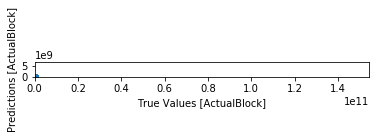

These are the actual block times and their predictions


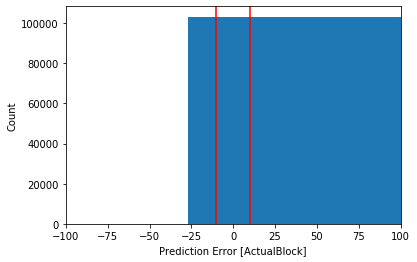

this is the median of error, negative indicates too early arrival, positive late arrival
-1.350555419921875
this is the average error, negative indicates too early arrival, positive late arrival
1472356.9206731198
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.19363901456070837
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.11732850236865815


In [0]:

print("This is linear Regression")
testModel(modelRE.predict(test_X), test_labels ,modelRE)


This is a simple Network


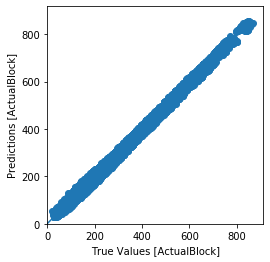

These are the actual block times and their predictions


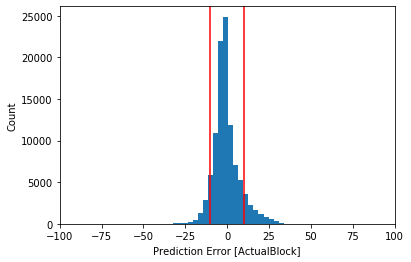

this is the median of error, negative indicates too early arrival, positive late arrival
-1.5540580749511719
this is the average error, negative indicates too early arrival, positive late arrival
5.678358989760034
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.16765643315927653
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.09669356635633532


In [0]:
print("This is a simple Network")
testModel(modSimple.predict(test_X).flatten(),test_labels,modSimple)


This is a deeper Network


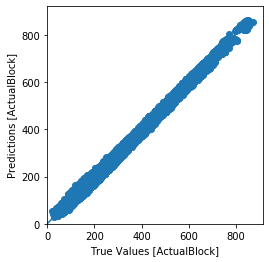

These are the actual block times and their predictions


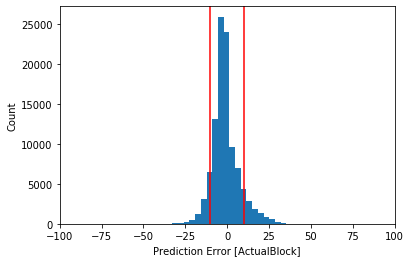

this is the median of error, negative indicates too early arrival, positive late arrival
-1.968414306640625
this is the average error, negative indicates too early arrival, positive late arrival
5.902537467424896
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.1782548463036339
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.09142342307431484


In [0]:
print("This is a deeper Network")
testModel(modDeep.predict(test_X).flatten(),test_labels,modDeep)


This is a wider Network


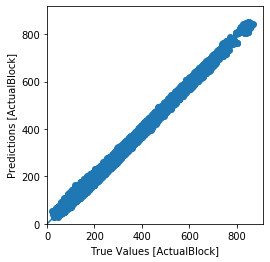

These are the actual block times and their predictions


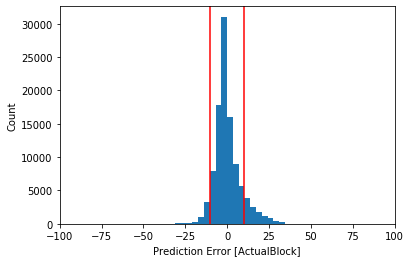

this is the median of error, negative indicates too early arrival, positive late arrival
-1.1484375
this is the average error, negative indicates too early arrival, positive late arrival
5.637193261191789
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.16254129409143311
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.1103145616771456


In [0]:
print("This is a wider Network")
testModel(modWider.predict(test_X).flatten(),test_labels,modWider)


This is a simple Network with costumized loss


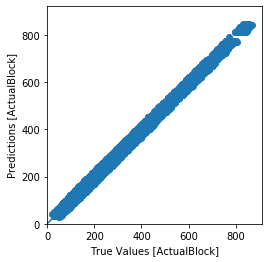

These are the actual block times and their predictions


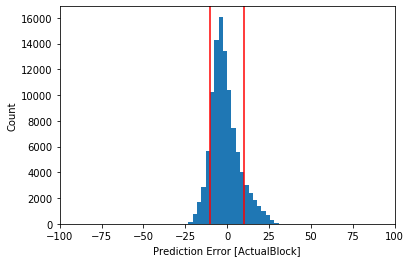

this is the median of error, negative indicates too early arrival, positive late arrival
-2.5903167724609375
this is the average error, negative indicates too early arrival, positive late arrival
6.760747362506418
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.2219854102283406
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.10692384449202212


In [0]:
print("This is a simple Network with costumized loss")
testModel(modSimple_loss.predict(test_X).flatten(),test_labels,modSimple_loss)


This is a deeper Network with costumized loss


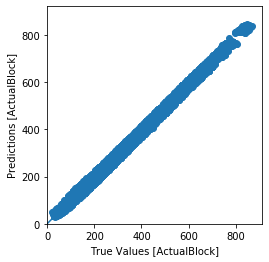

These are the actual block times and their predictions


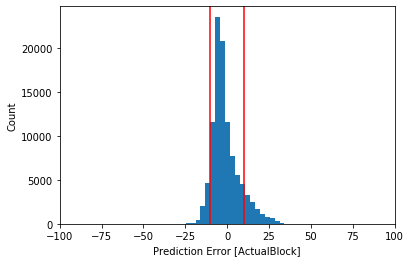

this is the median of error, negative indicates too early arrival, positive late arrival
-2.99700927734375
this is the average error, negative indicates too early arrival, positive late arrival
6.4508969657925075
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.18145180822103602
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.10983986127122831
[163.24124 273.53647  69.14369 ... 432.9916  645.19977 650.4992 ]


In [0]:
print("This is a deeper Network with costumized loss")
testModel(modDeep_loss.predict(test_X).flatten(),test_labels,modDeep_loss)
print(modDeep_loss.predict(test_X).flatten())

This is a wider Network with costumized loss


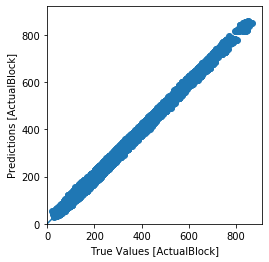

These are the actual block times and their predictions


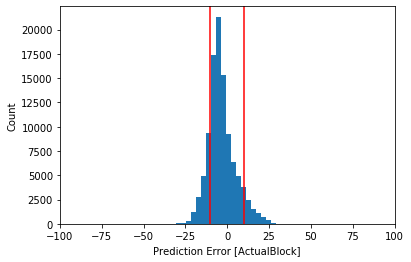

this is the median of error, negative indicates too early arrival, positive late arrival
-4.6137542724609375
this is the average error, negative indicates too early arrival, positive late arrival
7.2385424033403405
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.24323067533398565
this is the percentage of blocktimes whos predictions exceed by  more than + 10 minutes:
0.07320074014512269


In [0]:
print("This is a wider Network with costumized loss")
testModel(modWider_loss.predict(test_X).flatten(),test_labels,modWider_loss)

#try for best model


In [0]:
 def loss(y_true,y_pred):
            d= y_true -y_pred
            late = K.cast( K.greater(d,10),"float") *K.cast(K.square(d-10),"float32")
            early =  K.cast( K.less(d,-10),"float") *K.cast((K.square(d+10)),"float32")
            onTime= K.cast(0,"float32")
            return late+early+onTime



In [0]:
#load my best model
modSimple_loss = tf.keras.models.load_model("/content/modSimple_loss.h5", custom_objects={'loss': loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
predictions =modWider_loss.predict(test_X).flatten()

compare=pd.DataFrame(test_labels)
compare["predictions"]= predictions
compare["difference"] = abs(compare['ActualBlock']-compare['predictions'])
compare["difference"].sum()/len(compare) 


7.2385424033403405

In [0]:
predictions2 =modWider_loss.predict(allData).flatten()

compare2=pd.DataFrame(allData_labels)
compare2["predictions"]= predictions2
compare2["difference"] = abs(compare2['ActualBlock']-compare2['predictions'])
compare2["difference"].sum()/len(compare2) 

7.249813994942987

In [0]:
data_kopiert.shape

(516115, 17)

In [0]:
data_kopiert["predictions"]= predictions2
data_kopiert["difference"] = abs(data_kopiert['ActualBlock']-data_kopiert["predictions"])
print(abs(data_kopiert["difference"]).sum()/len(data_kopiert))
print(statistics.median(abs(data_kopiert["difference"])))
print(data_kopiert.head())


7.249813994942987
6.3932342529296875
   Acreg  Version           Std UTC  ... DiffBlock predictions difference
0  EIFHA  737-800  01.06.2017 05:20  ...         7  176.298386   8.298386
1  EIFHA  737-800  01.06.2017 08:55  ...         8  165.138321   7.861679
2  EIFHA  737-800  02.06.2017 06:00  ...         0  254.976242   4.976242
3  EIFHA  737-800  02.06.2017 16:15  ...        13  144.796951  12.796951
4  EIFHA  737-800  03.06.2017 05:40  ...         6  278.794250   9.794250

[5 rows x 19 columns]


In [0]:
data_kopiert.nlargest(100, "difference").to_csv("100worst.csv")

In [0]:
data_kopiert.to_csv("BlocktimesPredictions.csv")